### CT5141 Assignment 1 (Unit Commitment)

#### Jash Prakash Rana, Aidan Wallace

#### ID 22222806, 22225668

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp

# Import data
generator_info = pd.read_csv("generator_info.csv", delimiter=",")
demand = np.loadtxt("demand.csv")
solar_curve = np.loadtxt("solar_curve.csv")

# Objectives
CO2 = generator_info["CO2 (tons/MW)"].values
cost = generator_info["cost (EUR/MW)"].values

### Problem Formulation

Our challenge is to formulate two separate linear programming problems. The first program's objective ($LP_1$) is to minimise the cost of generating electricity while meeting the hourly demand of customers. The second program's objective ($LP_2$) is to minimise the $CO_2$ output of generating electricity while meeting the hourly demand of customers. 

The decision variables are $X_{ij}$, the amount of electricity to generate during hour $i$ of the day from generator $j$. We have 12 generators and 24 hours in a day. Therefore, we will have $12 \times 24 = 288$ decision variables.

The objective function for $LP_1$ is the **total cost ($C$)** of electricity generation over a full day (24 hours). The objective function which we want to minimise can be written as:

$$
C = \sum^{24}_{i=1} \left[ 1.4(X_{i1} + X_{i2} + X_{i3} + X_{i4}) + 4.4(X_{i5} + X_{i6} + X_{i7}) + 9.1X_{i8} + 9.5X_{i9} + 5.4(X_{i10} + X_{i11} + X_{i12}) \right] 
$$

The objective function for $LP_2$ is the **total $CO_2$ output ($CO2$)** of electricity generation over a full day (24 hours). The objective function which we want to minimise can be written as:

$$
CO2 = \sum^{24}_{i=1} \left[ 0.024(X_{i1} + X_{i2} + X_{i3} + X_{i4}) + 0.82(X_{i5} + X_{i6} + X_{i7}) + 0.49X_{i8} + 0.5X_{i9} \right]
$$

The constraints for both problems are the same. The constraints for $LP_1$ and $LP_2$ are given as follows,

Let,

- $d_i$ be the hourly demand for electricity.
- $L_{ij}$ is the lower bound on electricity generation for a generator $j$ during hour $i$.
- $ U_{ij}$ is the upper bound.
- $s_i$ be the solar curve value at a given hour.

Then, our constraints can be expressed as:

$$
\begin{aligned}
\sum^{12}_{j=1} X_{ij} &= d_i \ \forall \  i & demand \\
X_{ij} &= X_{1j}, \  for \  j \in \{ 4, 5, 6 \} \  \forall \  i > 1 & solid \  fuel \  generators \\
X_{ij} &\leq U_{ij}, \  for \  j \in \{1, 2, \ldots, 9\}  \ \forall \  i & upper \  bound \\
X_{ij} &\leq s_i U_{ij} \  for \  j \in \{10, 11, 12\} \  \forall \  i & solar \  curve \\
X_{ij} &\geq L_{ij}  \ \forall \  i & lower \  bound
\end{aligned}
$$

#### Application of Linear Programming
Linear programming is appropriate for this problem as the constraints and objective function are linear in form (i.e They can be expressed as linear combinations of decision variables and corresponding coefficients).

#### Implementation

We instantiate the `linearProg` class by passing in the data and creating a  _pywraplp.Solver_ object. We then add the decision variables and constraints to the _Solver_ by calling the `add_vars_and_constr` function. Once the problem is set up, we can call the `obj_fun` function and pass it a list of the objective function coefficients we wish to use (corresponding to the cost and $CO_2$ objectives) and finally call the `solve` function to get the optimal values of the decision variables for each  minimisation objective. The values are returned in a Pandas dataframe with columns representing the generators and rows representing the hours of the day.

In [2]:
class linearProg(object):

	def __init__(self, generator_info, demand, solar) -> None:
		# Data
		self.generator_info = generator_info
		self.demand = demand
		self.solar = solar

		# Variables
		self.ngenerators = len(generator_info["name"])
		self.nhours = 24 # hard-coded as unlikely to change

		# Objectives
		self.CO2 = generator_info["CO2 (tons/MW)"].values
		self.cost = generator_info["cost (EUR/MW)"].values

		# Bounds
		self.lb = generator_info["lower_bound (MW)"].values
		self.ub = generator_info["upper_bound (MW)"].values

		# Create the linear solver with the GLOP backend
		self.solver = pywraplp.Solver.CreateSolver('GLOP')

	def generator_type(self):
		# Generator types
		self.gen_type = dict()
		for i, type in enumerate(self.generator_info["type"].values):
			if type not in self.gen_type:
				self.gen_type[type] = []
			self.gen_type[type].append(i)
		return self.gen_type

	def add_vars_and_constr(self):
		# Create the decision variables
		self.decisionVar = [[0 for _ in range(self.nhours)] for _ in range(self.ngenerators)]
		for i in range(self.nhours):
			for j in np.concatenate([value for key, value in self.generator_type().items() if key in ['hydro', 'gas', 'solid']]):
				self.decisionVar[j][i] = self.solver.NumVar(self.lb[j], self.ub[j], f'X{i}{j}')
			for j in self.generator_type()["solar"]:
				# Upper bound for solar generators to account for solar curve (solar constraint)
				self.decisionVar[j][i] = self.solver.NumVar(self.lb[j], self.solar[i]*self.ub[j], f'X{i}{j}')

			# Demand constraints
			self.solver.Add(sum([var[i] for var in self.decisionVar]) == self.demand[i])
			
			# Constant solid generator type constraint
			for j in self.generator_type()["solid"]:
				if i > 0:
					self.solver.Add(self.decisionVar[j][i] == self.decisionVar[j][0])

	def add_obj_fun(self, obj_fun):
		# Create the objective function
		self.solver.Minimize(sum([sum(obj_fun[j]*np.array(self.decisionVar[j])) for j in range(self.ngenerators)]))

	def solve(self):
		status = self.solver.Solve()
		if status == pywraplp.Solver.OPTIMAL:
			decisionVarSol = pd.DataFrame([[0 for _ in range(self.ngenerators)] for _ in range(self.nhours)],
			columns=['X' + str(j) for j in range(1, self.ngenerators+1)])
			for j in range(self.ngenerators):
				for i in range(self.nhours):
					decisionVarSol.iloc[i, j] = self.decisionVar[j][i].solution_value()
		else:
			print('The problem does not have an optimal solution.')

		return decisionVarSol

The optimal solution for both the LP optimization problems are shown in the table below.

- The optimal objective function value for cost minimisation is €$157436.10$.
- The optimal objective function value for $CO_2$ minimisation is $18753.42$.

In [3]:
# Set up Linear Programme
lp = linearProg(generator_info=generator_info, demand=demand, solar=solar_curve)
lp.add_vars_and_constr()

# Cost Solution (LP1)
lp.add_obj_fun(cost)
lp1_sol = lp.solve()

# CO2 Solution (LP2)
lp.add_obj_fun(CO2)
lp2_sol = lp.solve()

# Electricity generation per generator per day
lp1_gen = lp1_sol.sum(axis=0)
lp2_gen = lp2_sol.sum(axis=0)

# Cost of both solutions per generator per day
lp1_cost = lp1_sol.multiply(cost, axis=1).sum(axis=0)
lp2_cost = lp2_sol.multiply(cost, axis=1).sum(axis=0)

# CO2 of both solutions per generator per day
lp1_co2 = lp1_sol.multiply(CO2, axis=1).sum(axis=0)
lp2_co2 = lp2_sol.multiply(CO2, axis=1).sum(axis=0)

# Cost of both solutions per generator type per day
lp1_cost_gen_type = [lp1_cost[values].sum() for values in lp.generator_type().values()]
lp2_cost_gen_type = [lp2_cost[values].sum() for values in lp.generator_type().values()]

# CO2 of both solutions per generator type per day
lp1_co2_gen_type = [lp1_co2[values].sum() for values in lp.generator_type().values()]
lp2_co2_gen_type = [lp2_co2[values].sum() for values in lp.generator_type().values()]

# Totals
print("Optimal Objective Function Values:")
print(tabulate([['Cost (LP1)', lp1_cost.values.sum(), lp1_co2.values.sum()], 
				['CO2 (LP2)', lp2_cost.values.sum(), lp2_co2.values.sum()]], 
				headers=['Minimise', 'Cost Value', 'CO2 Value'], floatfmt = ".2f"))

Optimal Objective Function Values:
Minimise      Cost Value    CO2 Value
----------  ------------  -----------
Cost (LP1)     157436.10     23201.99
CO2 (LP2)      212148.20     18753.42


In [4]:
# Totals per generator type per day
print("Total Cost and CO2 Output Per Generator Type Per Day:")
print(tabulate([['Cost (LP1)'] + lp1_cost_gen_type, 
				['Cost (LP2)'] + lp2_cost_gen_type, 
				['CO2 (LP1)'] + lp1_co2_gen_type, 
				['CO2 (LP2)'] + lp2_co2_gen_type], 
				headers=['Minimise'] + list(lp.generator_type().keys()), floatfmt = ".2f"))

Total Cost and CO2 Output Per Generator Type Per Day:
Minimise      hydro      solid        gas    solar
----------  -------  ---------  ---------  -------
Cost (LP1)  8027.60  113942.40   34013.50  1452.60
Cost (LP2)  8400.00   59875.20  138527.00  5346.00
CO2 (LP1)    137.62   21234.72    1829.65     0.00
CO2 (LP2)    144.00   11158.56    7450.86     0.00


The table above gives a breakdown of the optimal solution values by generator type. We can see that Solid type generators contribute the most to total cost in $LP_1$ and Gas type generators contribute the most to cost in $LP_2$. Solid type generators produce the most $CO_2$ in $LP_1$ as well as in $LP_2$.

The figure below contains 3 Heatmaps in  which: <br>
1. Heatmap of $LP_1$: Shows the output generation of each generator for each hour for $LP_1$ solution.
2. Heatmap of $LP_2$: Shows the output generation of each generator for each hour for $LP_2$ solution.
3. Difference between $LP_1$ and $LP_2$: Shows the difference in optimal generator output between cost minimisation and $CO_2$ minimisation. The negative values in Heatmap 3 show that the generators in $LP_1$ had less output than in $LP_2$, vice versa.

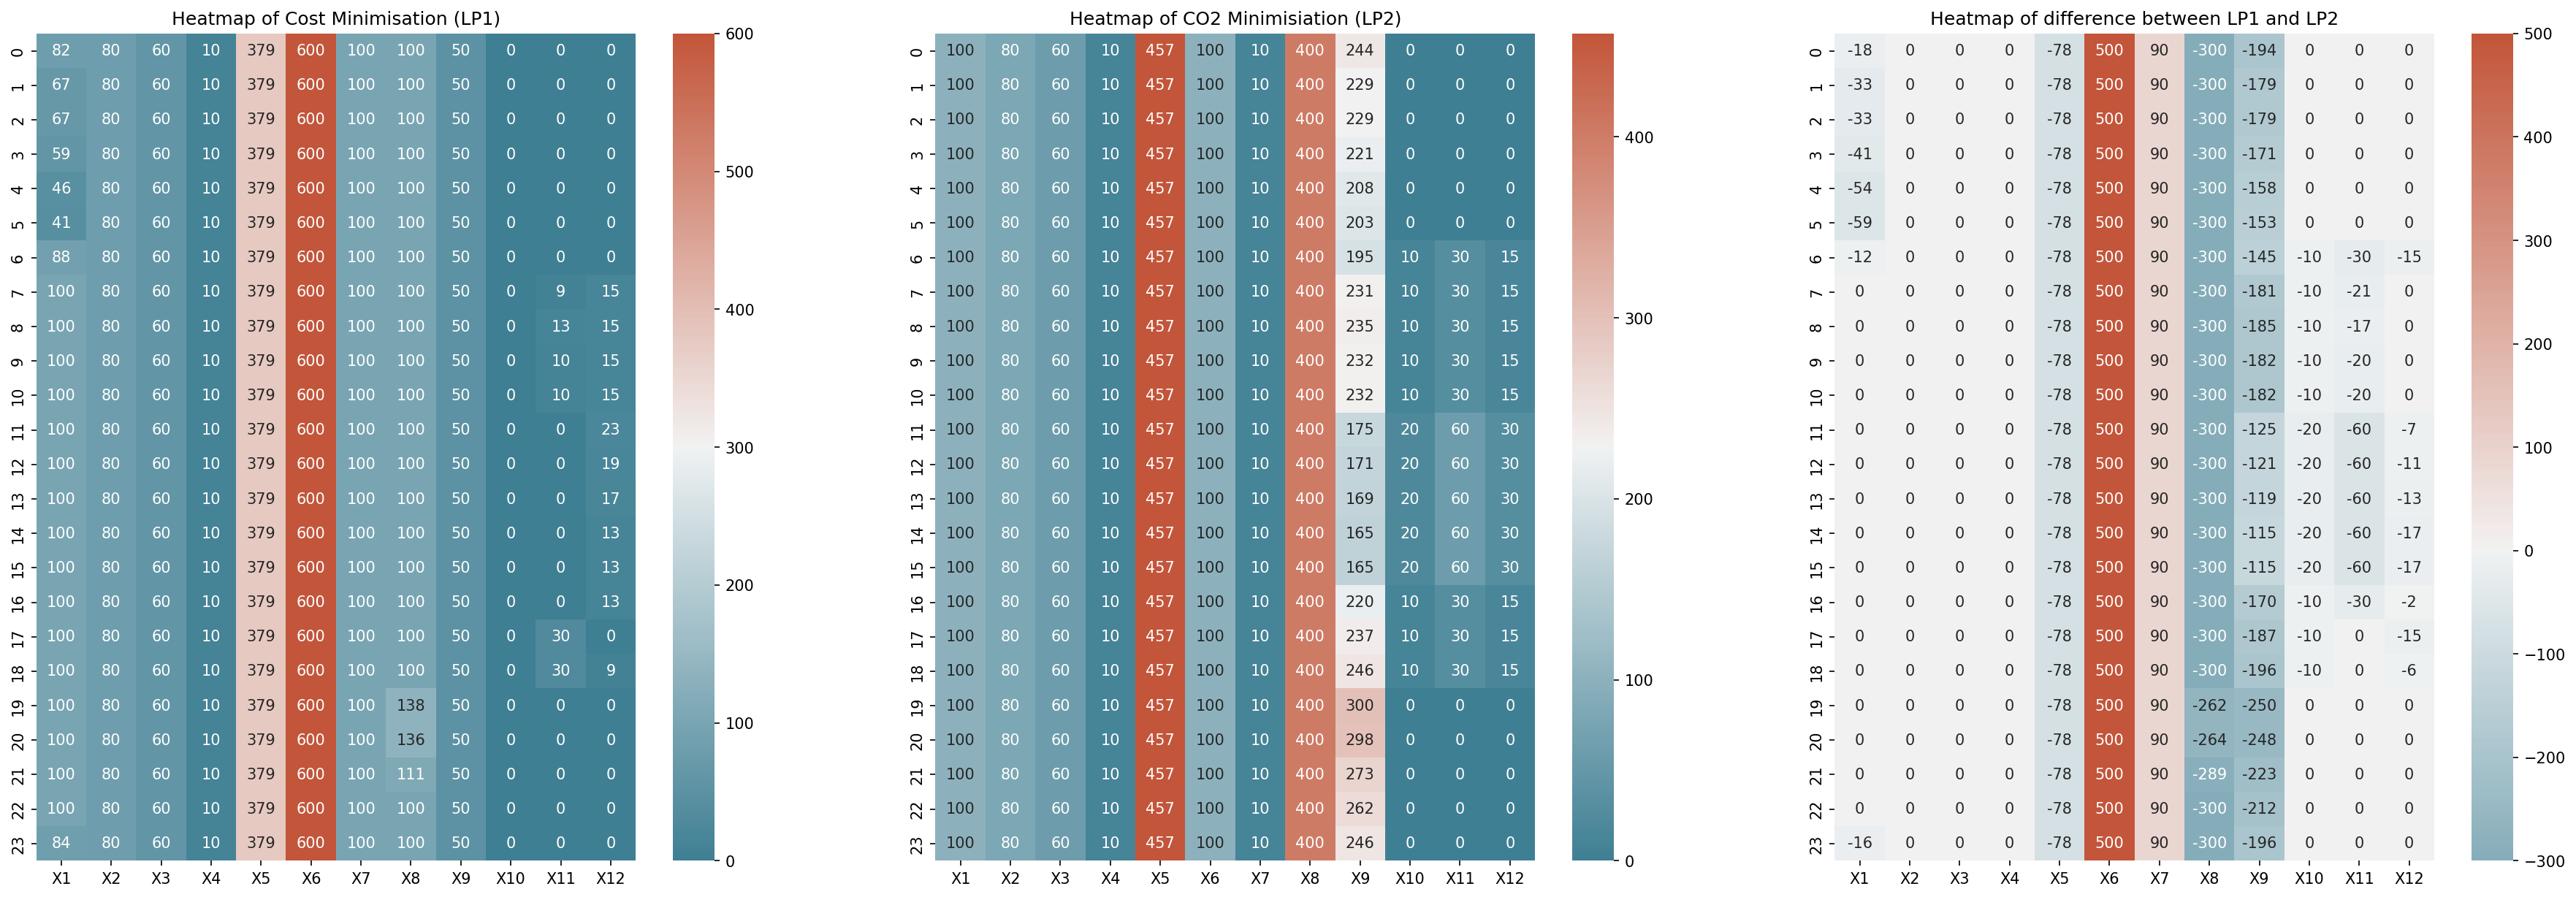

In [5]:
# Heatmaps of solutions

figure, axis = plt.subplots(1, 3, figsize=(30,10), dpi = 150)
hm1 = sns.heatmap(ax=axis[0], data = lp1_sol, fmt='.0f', annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
hm2 = sns.heatmap(ax=axis[1], data = lp2_sol, fmt='.0f', annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
hm3 = sns.heatmap(ax=axis[2], data = lp1_sol - lp2_sol, fmt='.0f', center=0, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

axis[0].set_title("Heatmap of Cost Minimisation (LP1)")
axis[1].set_title("Heatmap of CO2 Minimisiation (LP2)")
axis[2].set_title("Heatmap of difference between LP1 and LP2")
plt.show()

The barplots below show us the optimal generator output per day for each minimisation solution. The key inference of this is:
* The generation of Gas generators($X_8$, $X_9$) has drastically increased in $LP_2$ solution as the $CO_2$ output is less for Gas generators than for other generator types. 
* The $LP_1$ solution shows that $X_6$ (Solid type generator) works on its upper bound while in $LP_2$ solution, we see it being used less and its alternate $X_5$ is used more.
* Even though Solar generators ($X_{10}$, $X_{11}$, $X_{12}$) have the lowest coefficient in the $CO_2$ minimisation objective function, we see very small values of them in the bargraph as:
    1. For 11 hours, they are not working (value is 0)
    2. For 8 hours, they work only on 50% generation
    3. For only 5 hours, they are permitted to work on full output generation

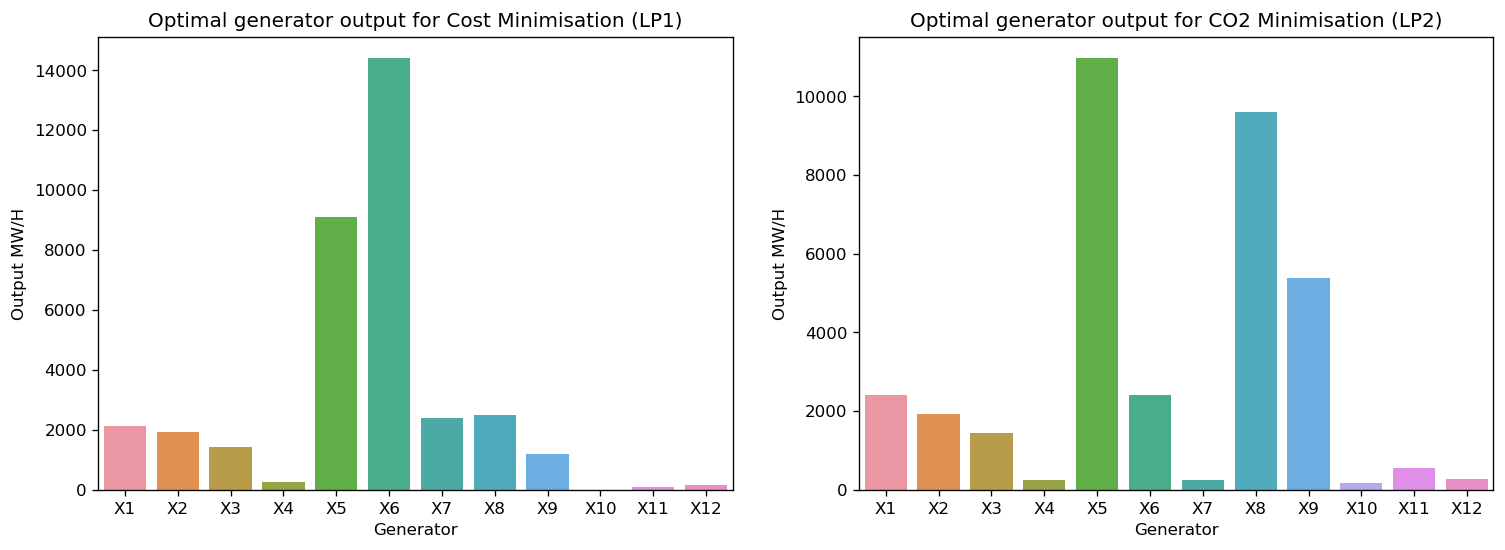

In [6]:
# Barplots - Generator Output
figure, axis = plt.subplots(1, 2, figsize=(15,5), dpi = 120)
bp1 = sns.barplot(ax = axis[0], x=lp1_gen.index, y=lp1_gen)
bp2= sns.barplot(ax = axis[1], x=lp2_gen.index, y=lp2_gen)

axis[0].set_title("Optimal generator output for Cost Minimisation (LP1)")
axis[0].set_xlabel("Generator")
axis[0].set_ylabel("Output MW/H")
axis[1].set_title("Optimal generator output for CO2 Minimisation (LP2)")
axis[1].set_xlabel("Generator")
axis[1].set_ylabel("Output MW/H")
plt.show()

The barplots below show us the total costs per generator per day for each minimisation solution. The key inference of this is:
* The $LP_1$ diagram shows Solid generator $X_6$ to be the costliest with a total cost per day of €$63360$.
* The $LP_2$ diagram shows Gas generator $X_8$ to be the costliest with a value of €$87360$. Generators $X_9$ and $X_5$ are the second and third largest contributers and contribute roughly the same amount.

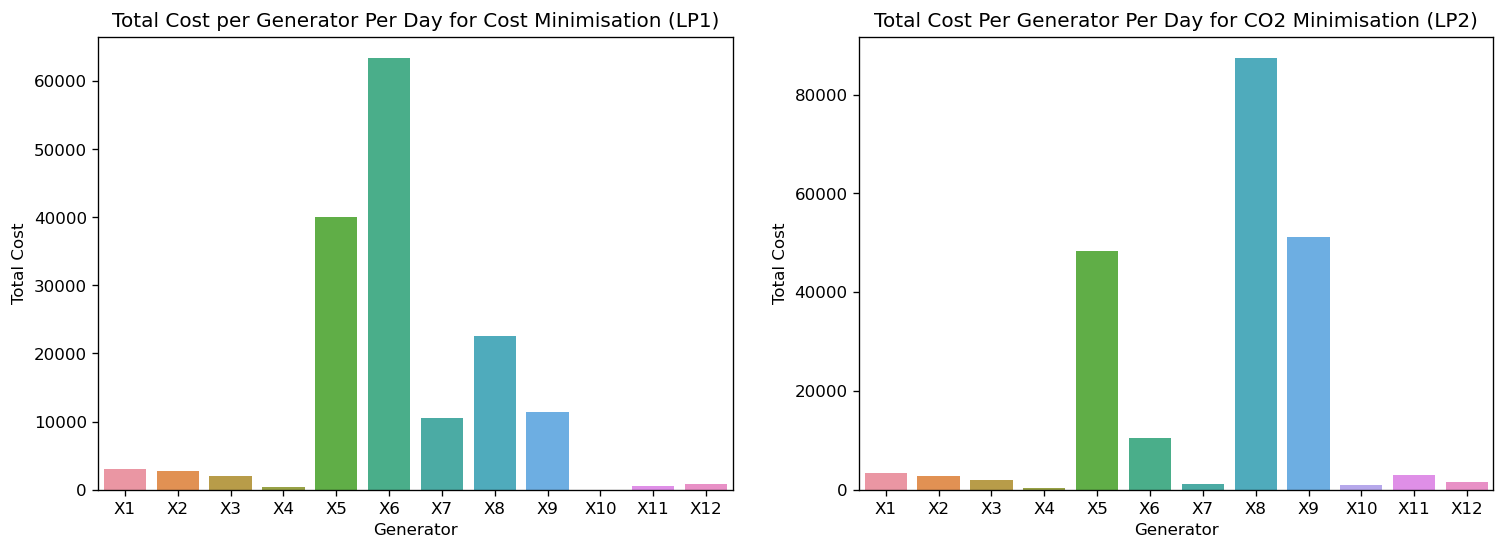

In [7]:
# Barplots - Total Cost
figure, axis = plt.subplots(1, 2, figsize=(15,5), dpi = 120)
bp1 = sns.barplot(ax = axis[0], x=lp1_cost.index, y=lp1_cost)
bp2= sns.barplot(ax = axis[1], x=lp2_cost.index, y=lp2_cost)

axis[0].set_title("Total Cost per Generator Per Day for Cost Minimisation (LP1)")
axis[0].set_xlabel("Generator")
axis[0].set_ylabel("Total Cost")
axis[1].set_title("Total Cost Per Generator Per Day for CO2 Minimisation (LP2)")
axis[1].set_xlabel("Generator")
axis[1].set_ylabel("Total Cost")
plt.show()

The following barplots show us the total CO2 output per generator per day for each minimisation solution. The key inference of this is:
* The $LP_1$ diagram shows Solid generator $X_6$ to be the highest with an output of $11808$ followed by generator $X_5$.
* The $LP_2$ diagram shows Solid generator $X_5$ to be the highest with an output of $8993$. Gas generators $X_8$ and $X_9$ also contribute heavily to $CO_2$ output.

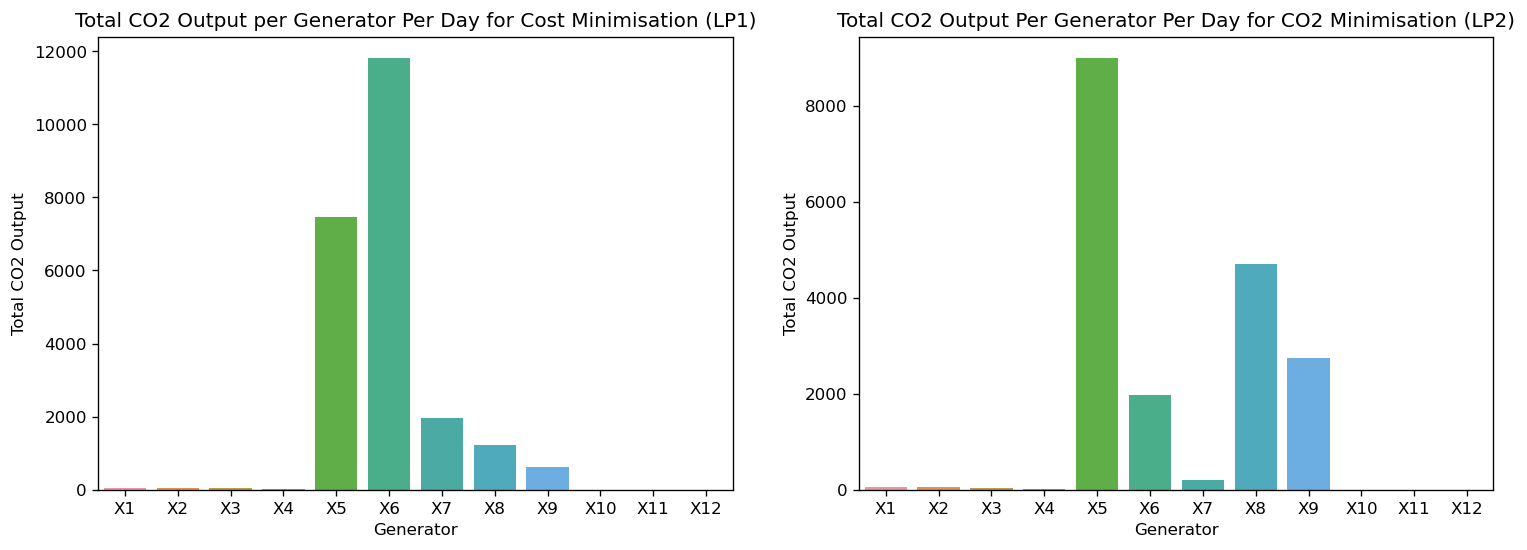

In [8]:
# Barplots - Total CO2
figure, axis = plt.subplots(1, 2, figsize=(15,5), dpi = 120)
bp1 = sns.barplot(ax = axis[0], x=lp1_co2.index, y=lp1_co2)
bp2= sns.barplot(ax = axis[1], x=lp2_co2.index, y=lp2_co2)

axis[0].set_title("Total CO2 Output per Generator Per Day for Cost Minimisation (LP1)")
axis[0].set_xlabel("Generator")
axis[0].set_ylabel("Total CO2 Output")
axis[1].set_title("Total CO2 Output Per Generator Per Day for CO2 Minimisation (LP2)")
axis[1].set_xlabel("Generator")
axis[1].set_ylabel("Total CO2 Output")
plt.show()

### Multiple Equal Optima

By changing the values of variables that have the same coefficients in the objective function and are not on their bounds, we can find different sets of decision variables that have the same optimal objective function values. 

For example in $LP_1$, the amount of electricity generated by solar generators from 11:00 to 12:00 ($i=12$) is $X_{10} = 0$, $X_{11} = 0$, $X_{12} = 23$, If we compare the generators outputs to their bounds, we see that $X_{10}$ and $X_{11}$ are on their lower bound while $X_{12}$ falls inbetween its upper and lower bounds. Since solar generators $X_{10}$ and $X_{11}$ are on their lower bounds, we can increase their value without moving outside of our bounds. Similarly, with solar generator $X_{12}$, we can increase or decrease its output without moving outide of its bounds. Only changing the output of one of the solar generators would change the objective function value as well as direspecting our demand constraint, but if we decrease the output from solar generator $X_{12}$ by say 2 units and increase solar generator $X_{11}$ by 2 units, we keep the objective value constant since both generators have the same coefficient in the objective function and we ensure that all of our demand constraints are met as we are still producing the same amount of electricity. Therefore, we have a different set of decision variables that lead to the same objective function value and meet all of our constraints, hence mutiple equal optima. 